In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.datasets import mnist

In [3]:
def create_pairs(x, y):

    pairs = []
    labels = []

    digit_indices = [np.where(y == i)[0] for i in range(10)]

    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            labels += [1]

            dn = (d + np.random.randint(1, 10)) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")



print("Loading MNIST data...")
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

train_pairs, train_labels = create_pairs(x_train, y_train)
test_pairs, test_labels = create_pairs(x_test, y_test)

print(f"Total training pairs: {len(train_pairs)}")

Loading MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total training pairs: 108400


In [4]:
def build_embedding_network(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(64, activation=None),
    ], name="Embedding_Network")
    return model

input_shape = (28, 28, 1)
base_network = build_embedding_network(input_shape)

input_a = layers.Input(shape=input_shape, name="Left_Input")
input_b = layers.Input(shape=input_shape, name="Right_Input")

en_a = base_network(input_a)
en_b = base_network(input_b)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

distance = layers.Lambda(euclidean_distance, name="Distance_Layer")([en_a, en_b])

siamese_model = models.Model(inputs=[input_a, input_b], outputs=distance)

In [5]:
def contrastive_loss(y_true, y_pred):

    margin = 1.0
    sq_dist = K.square(y_pred)
    margin_sq = K.square(K.maximum(margin - y_pred, 0))

    return K.mean(y_true * sq_dist + (1 - y_true) * margin_sq)

siamese_model.compile(loss=contrastive_loss, optimizer='adam')

In [6]:
print("Starting training...")
history = siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],
    train_labels,
    batch_size=128,
    epochs=15,
    validation_split=0.1,
    verbose=1
)

Starting training...
Epoch 1/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - loss: 0.0845 - val_loss: 0.1455
Epoch 2/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 77s 101ms/step - loss: 0.0307 - val_loss: 0.2131
Epoch 3/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 75s 98ms/step - loss: 0.0254 - val_loss: 0.2807
Epoch 4/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 75s 98ms/step - loss: 0.0232 - val_loss: 0.3841
Epoch 5/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 90s 108ms/step - loss: 0.0216 - val_loss: 0.4433
Epoch 6/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 142s 108ms/step - loss: 0.0202 - val_loss: 0.5626
Epoch 7/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 138s 104ms/step - loss: 0.0194 - val_loss: 0.6781
Epoch 8/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - loss: 0.0188 - val_loss: 0.7202
Epoch 9/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - loss: 0.0179 - val_loss: 0.8860
Epoch 10/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 87s 109ms/step - loss: 0.0174 - val_loss: 1.0170
Epoch 11/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 143s 110ms/step - loss: 0.0170 - val_loss: 1.19


--- Evaluation on Test Pairs ---
Pair Label: SIMILAR (Genuine) | Predicted Distance: 0.0292
Pair Label: SIMILAR (Genuine) | Predicted Distance: 0.0323
Pair Label: SIMILAR (Genuine) | Predicted Distance: 0.0653
Pair Label: DISSIMILAR (Forgery) | Predicted Distance: 1.0111
Pair Label: DISSIMILAR (Forgery) | Predicted Distance: 1.0770
Pair Label: DISSIMILAR (Forgery) | Predicted Distance: 0.9738


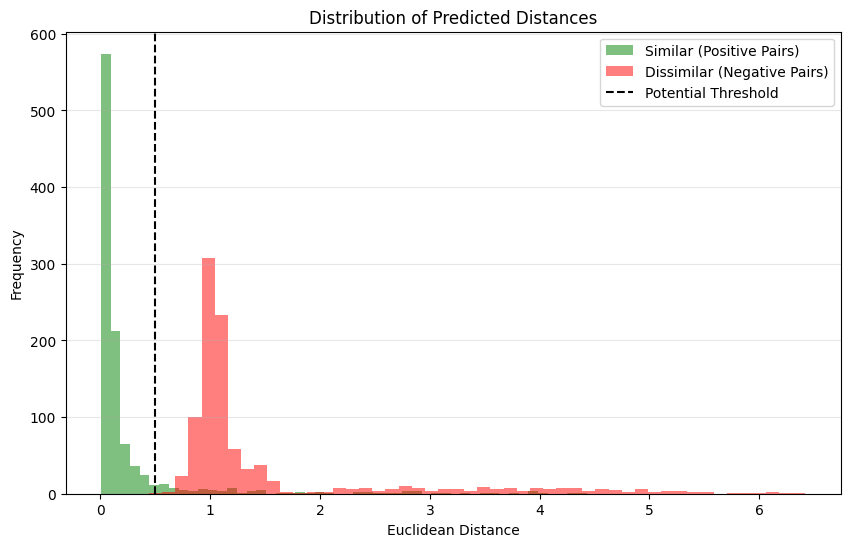

In [7]:
def show_sample_predictions():
    print("\n--- Evaluation on Test Pairs ---")
    pos_indices = np.where(test_labels == 1)[0][:3]
    neg_indices = np.where(test_labels == 0)[0][:3]

    indices = np.concatenate([pos_indices, neg_indices])

    for idx in indices:
        pair = test_pairs[idx]
        label = "SIMILAR (Genuine)" if test_labels[idx] == 1 else "DISSIMILAR (Forgery)"

        dist = siamese_model.predict([pair[0:1], pair[1:2]], verbose=0)[0][0]
        print(f"Pair Label: {label} | Predicted Distance: {dist:.4f}")

show_sample_predictions()

def plot_distance_distribution(model, pairs, labels):
    subset_size = 2000
    indices = np.random.choice(len(pairs), subset_size, replace=False)
    p_subset = pairs[indices]
    l_subset = labels[indices]

    distances = model.predict([p_subset[:, 0], p_subset[:, 1]], verbose=0).flatten()

    pos_distances = distances[l_subset == 1]
    neg_distances = distances[l_subset == 0]

    plt.figure(figsize=(10, 6))
    plt.hist(pos_distances, bins=50, alpha=0.5, label='Similar (Positive Pairs)', color='green')
    plt.hist(neg_distances, bins=50, alpha=0.5, label='Dissimilar (Negative Pairs)', color='red')
    plt.axvline(x=0.5, color='black', linestyle='--', label='Potential Threshold')
    plt.title('Distribution of Predicted Distances')
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()


plot_distance_distribution(siamese_model, test_pairs, test_labels)